### Notebook provides data visualizations for: 

* **Most expensive treatments**

* **Most expensive treatments for each state**

* **Rank by cost at each state (per treatment)**

* **Shows cheaper providers that are available within the state (per treatment)**

* **Normalized distribution of inpatients across treatments for each state**

============================================================================

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('inpatientCharges_subset.csv')

In [3]:
print("Unique DRG's: %d" % df['DRG Definition'].unique().shape)
print("Unique Provider ID's: %d" % df['Provider Id'].unique().shape)
print("Unique Cities: %d" % df['Provider City'].unique().shape)

Unique DRG's: 100
Unique Provider ID's: 103
Unique Cities: 8


In [4]:
# remove white spaces from left and right of column names
df.columns = [column.strip() for column in df.columns]

In [5]:
# remove dollar signs
for column in ['Average Covered Charges', 'Average Total Payments', 'Average Medicare Payments']:
    df[column] = df[column].map(lambda x: x[1:])
    df[column] = pd.to_numeric(df[column])

In [6]:
# get 'DRG Definition' and 'Total Discharges' columns, group by 'DRG Definition' and count number of discharges per 
# 'DRG Definition'.  In summary, this code tells us how many discharges exist for each 'DRG Definition'.
agg_columns = ['count']
groupby_drg = df[['DRG Definition', 'Total Discharges']].groupby(by='DRG Definition').agg(agg_columns)
groupby_drg.columns = groupby_drg.columns.get_level_values(0)

In [7]:
# get top N DRG's determined by Total Discharges
num_drgs = 1
top_drg = groupby_drg[:num_drgs].sort_values(by='Total Discharges', ascending=[False])

In [8]:
# display top num_drgs DRG's
for drg in top_drg.iterrows():
    print(drg[0])

039 - EXTRACRANIAL PROCEDURES W/O CC/MCC


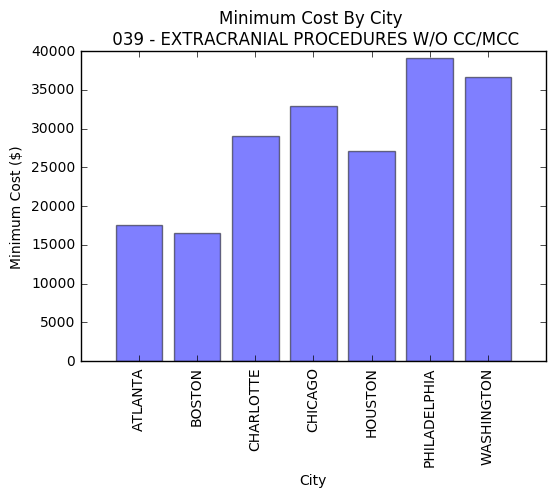

In [9]:
# display costs by city for num_drgs most common procedures

for drg in top_drg.iterrows():

    specific_drg = df[ df['DRG Definition'] == drg[0] ]
    
    drg_cost_by_city = specific_drg.pivot_table(index='Provider City', columns='DRG Definition', values='Average Covered Charges', aggfunc='min')
    
    cities = [ drg_cost_by_city.index[city_index] for city_index in range(drg_cost_by_city.index.shape[0]) ]
    
    min_charges = [ drg_cost_by_city.values[city_index][0] for city_index in range(drg_cost_by_city.index.shape[0]) ]
    
    drg = drg_cost_by_city.columns[0]
    
    # bar plot
    y_pos = np.arange(len(cities))
    plt.bar(y_pos, min_charges, align='center', alpha=0.5)
    plt.xticks(y_pos, cities, rotation=90)
    plt.ylabel('Minimum Cost ($)')
    plt.xlabel('City')
    plt.title('Minimum Cost By City \n ' + drg )
    plt.show()


In [10]:
# DRG 
client_drg = '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC'

# Hub and Spokes
hub = 'HOUSTON'

# Survey Results
beta = {
        'person_a': 0.2,
        'person_b': 1.0,
        'person_c':0.6
       }

In [11]:
travel_costs = pd.read_csv('travel_cost_matrix.csv',index_col=0)

In [12]:
# Get all records for client_drg
specific_drg = df[ df['DRG Definition'] == client_drg ]

# pivot table: rows = Provider City, columns = DRG Definition, values = Minimum Average Covered Charges
drg_cost_by_city = specific_drg.pivot_table(index='Provider City', 
                                            columns='DRG Definition', 
                                            values='Average Covered Charges', 
                                            aggfunc='min')

# cost of DRG in hub city
hub_drg_cost = {hub:drg_cost_by_city.ix[hub][0]}

# cost of DRG in spoke cities
spoke_drg_costs = dict()

for drg_cost_spoke in drg_cost_by_city.index[:]:
    
    if drg_cost_spoke not in hub:
        spoke_drg_costs[drg_cost_spoke] = drg_cost_by_city.ix[drg_cost_spoke][0]


In [13]:
print(hub_drg_cost)
print(spoke_drg_costs)

{'HOUSTON': 27120.73}
{'BOSTON': 16529.98, 'PHILADELPHIA': 39054.809999999998, 'WASHINGTON': 36636.040000000001, 'ATLANTA': 17527.91, 'CHICAGO': 32857.699999999997, 'CHARLOTTE': 28982.419999999998}


In [14]:
# calcuate cost of sending client for DRG for each spoke city
total_spoke_costs = dict()

for spoke,spoke_cost in spoke_drg_costs.items():
    
    total_spoke_costs[spoke] = spoke_cost + \
                               travel_costs[hub][spoke] + \
                               beta['person_a'] * (0.5 * np.abs( hub_drg_cost[hub] - spoke_cost ) )

In [15]:
# savings per city
print("The cost of having the procedure done in %s is $%d\n" % (hub,hub_drg_cost[hub]))

for spoke_city, spoke_cost in total_spoke_costs.items():
#     cost_diff = hub_drg_cost[hub] - spoke_cost
    print("The cost of having the procedure done in %s is $%d" % (spoke_city, spoke_cost) )

The cost of having the procedure done in HOUSTON is $27120

The cost of having the procedure done in BOSTON is $17878
The cost of having the procedure done in WASHINGTON is $37928
The cost of having the procedure done in ATLANTA is $18761
The cost of having the procedure done in PHILADELPHIA is $40614
The cost of having the procedure done in CHARLOTTE is $29481
The cost of having the procedure done in CHICAGO is $33716


In [18]:
# get radar axes after scales
import pygal

radar_chart = pygal.Radar()
radar_chart.title = 'cost of the procedure'
radar_chart.x_labels = ['HOUSTON', 'PHILADELPHIA', 'ATLANTA', 'CHICAGO', 'CHARLOTTE', 'BOSTON','WASHINGTON']
radar_chart.add('total costs', [27120, 40614, 18761, 33716,29481,17878, 37928])
radar_chart.render_to_file('radar_chart.svg')


AttributeError: 'Radar' object has no attribute 'show'